In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import scipy as osp

import sys
sys.path.insert(0, '../')

import structure_model_lib
import structure_optimization_lib as str_opt_lib
import preconditioner_lib 

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import data_utils

import matplotlib.pyplot as plt
%matplotlib inline  

from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 40
n_pop = 4

In [4]:
# population allele frequencies
true_pop_allele_freq = np.random.random((n_loci, n_pop))

# individual admixtures
true_ind_admix_propn = np.random.dirichlet(np.ones(n_pop) / n_pop, size = (n_obs))

# cluster the individuals
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

# draw data
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)



In [5]:
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

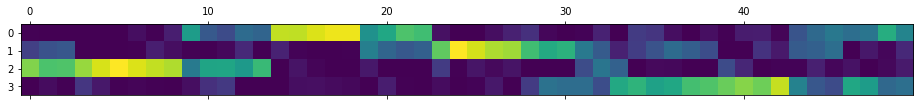

In [6]:
plt.matshow(true_ind_admix_propn.T)

In [7]:
g_obs.shape

(50, 40, 3)

# Get prior

In [8]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [9]:
k_approx = 4

In [10]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [11]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)

## Initialize 

In [12]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks)

# Optimize

In [13]:
vb_opt_free_params = \
    str_opt_lib.optimize_structure(g_obs, vb_params_dict, vb_params_paragami,
                                prior_params_dict,
                                gh_loc, gh_weights,
                                use_logitnormal_sticks = use_logitnormal_sticks,
                                run_cavi = True,
                                cavi_max_iter = 100,
                                cavi_tol = 1e-2,
                                netwon_max_iter = 20,
                                max_precondition_iter = 25,
                                gtol=1e-8, ftol=1e-8, xtol=1e-8,
                                approximate_hessian = True)

vb_opt_dict = vb_params_paragami.fold(vb_opt_free_params, free=True)

iteration [0]; kl:3369.100652
iteration [1]; kl:3093.487351
iteration [2]; kl:3042.477997
iteration [3]; kl:3023.308631
iteration [4]; kl:3013.636864
iteration [5]; kl:3007.852735
iteration [6]; kl:3004.006019
iteration [7]; kl:3001.263703
iteration [8]; kl:2999.216139
iteration [9]; kl:2997.638612
iteration [10]; kl:2996.396288
iteration [11]; kl:2995.402195
iteration [12]; kl:2994.596996
iteration [13]; kl:2993.938464
iteration [14]; kl:2993.395585
iteration [15]; kl:2992.945026
iteration [16]; kl:2992.568905
iteration [17]; kl:2992.253308
iteration [18]; kl:2991.987278
iteration [19]; kl:2991.762096
iteration [20]; kl:2991.570759
iteration [21]; kl:2991.407604
iteration [22]; kl:2991.268019
iteration [23]; kl:2991.148224
iteration [24]; kl:2991.045105
iteration [25]; kl:2990.956089
iteration [26]; kl:2990.879035
iteration [27]; kl:2990.812157
iteration [28]; kl:2990.753963
iteration [29]; kl:2990.703197
iteration [30]; kl:2990.658802
iteration [31]; kl:2990.619886
iteration [32]; kl

In [14]:
vb_params_dict = deepcopy(vb_opt_dict)

# Check results

In [15]:
if use_logitnormal_sticks: 
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_opt_dict['ind_mix_stick_propn_mean'], 
                        vb_opt_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)

else: 
    ind_mix_stick_beta_params = vb_opt_dict['ind_mix_stick_beta_params']
    e_stick_lengths = \
            modeling_lib.get_e_beta(ind_mix_stick_beta_params)
    e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

e_pop_freq = modeling_lib.get_e_beta(vb_opt_dict['pop_freq_beta_params'])

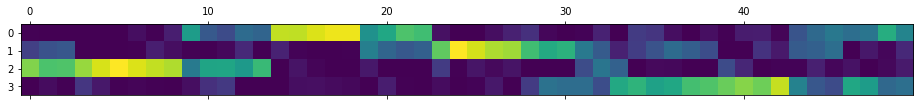

In [16]:
plt.matshow(true_ind_admix_propn.T)

# Sensitivities

### Get sensitivity class

In [17]:
get_kl_from_vb_free_prior_free = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

In [18]:
objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, use_logitnormal_sticks, 
                                                                    gh_loc, gh_weights)

In [19]:
t0 = time.time()

vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = objective_fun,
        opt_par_value = vb_opt_free_params, 
        hyper_par_value = prior_params_paragami.flatten(prior_params_dict, free=True),
        validate_optimum=False,
        factorize_hessian=True,
        hyper_par_objective_fun=None,
        grad_tol=1e-8)

print('time: {:.08}sec'.format(time.time() - t0))

time: 10.99299sec


## Preconditioned CG?

In [20]:
mfvb_cov, mfvb_info = preconditioner_lib.get_mfvb_cov_preconditioner(vb_params_dict, vb_params_paragami,
                        use_logitnormal_sticks)

In [21]:
hvp = autograd.hessian_vector_product(objective_fun, argnum=0)

In [22]:
opt0 = deepcopy(vb_opt_free_params)
hyper0 = deepcopy(prior_params_paragami.flatten(prior_params_dict, free=True))

In [23]:
system_solver = preconditioner_lib.SystemSolverFromHVP(hvp, opt0, hyper0)

In [24]:
_hyper_obj_fun_grad = \
            autograd.grad(objective_fun, argnum=0)
_hyper_obj_cross_hess = autograd.jacobian(
    _hyper_obj_fun_grad, argnum=1)

In [25]:
cross_hess = _hyper_obj_cross_hess(opt0, hyper0)

In [26]:
sens_mat = - system_solver.solve(cross_hess)

In [27]:
# check against our old sensitivity matrix
np.max(np.abs(vb_sens._sens_mat - sens_mat))

3.173510972132726e-05

In [28]:
# check the new arguments to HyperparameterSensitivityLinearApproximation
# with my new solver

In [29]:
t0 = time.time()

vb_sens2 = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = objective_fun,
        opt_par_value = vb_opt_free_params, 
        hyper_par_value = prior_params_paragami.flatten(prior_params_dict, free=True),
        validate_optimum=False,
        factorize_hessian=True,
        hyper_par_objective_fun=None,
        grad_tol=1e-8, 
        system_solver=system_solver,
        compute_hess=False)

print('time: {:.08}sec'.format(time.time() - t0))

time: 6.6461308sec


In [30]:
np.max(np.abs(vb_sens._sens_mat - vb_sens2._sens_mat))

3.173510972132726e-05

In [31]:
# Now check with preconditioner
system_solver2 = preconditioner_lib.SystemSolverFromHVP(hvp, opt0, hyper0, 
                                    cg_opts = {'M': mfvb_info})

In [32]:
t0 = time.time()

vb_sens3 = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = objective_fun,
        opt_par_value = vb_opt_free_params, 
        hyper_par_value = prior_params_paragami.flatten(prior_params_dict, free=True),
        validate_optimum=False,
        factorize_hessian=True,
        hyper_par_objective_fun=None,
        grad_tol=1e-8, 
        system_solver=system_solver2,
        compute_hess=False)

print('time: {:.08}sec'.format(time.time() - t0))

time: 4.9566038sec


In [33]:
np.max(np.abs(vb_sens._sens_mat - vb_sens3._sens_mat))

4.4442811021672135e-05